# `❤️ Import Libraries`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import Ridge
from prophet import Prophet

# Display options
pd.set_option('display.float_format', '{:,.2f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')

# `❤️ Load Dataset`

In [ ]:
df = pd.read_csv("cement_data.csv")
df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Month         155 non-null    object 
 1   Production    155 non-null    float64
 2   Sales         155 non-null    float64
 3   demand        155 non-null    float64
 4   population    155 non-null    float64
 5   gdp           155 non-null    float64
 6   disbusment    155 non-null    float64
 7   interestrate  155 non-null    float64
 8   Unnamed: 8    0 non-null      float64
 9   Unnamed: 9    0 non-null      float64
 10  Unnamed: 10   0 non-null      float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   0 non-null      float64
 13  Unnamed: 13   0 non-null      float64
dtypes: float64(13), object(1)
memory usage: 109.4+ KB


(    Month  Production  Sales   demand  population        gdp  disbusment  \
 0  Jan-10      347.00  322.00  346.00      122.40 182,277.00   60,314.00   
 1  Feb-10      306.00  285.00  338.00      122.50 181,018.00   61,213.92   
 2  Mar-10      236.00  245.00  276.00      122.60 179,759.00   62,113.83   
 3  Apr-10      234.00  212.00  245.00      122.80 178,500.00   63,013.75   
 4  May-10      296.00  289.00  312.00      122.90 177,354.00   63,913.67   
 
    interestrate  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
 0         10.25         NaN         NaN          NaN          NaN   
 1         10.33         NaN         NaN          NaN          NaN   
 2         10.42         NaN         NaN          NaN          NaN   
 3         10.50         NaN         NaN          NaN          NaN   
 4         10.58         NaN         NaN          NaN          NaN   
 
    Unnamed: 12  Unnamed: 13  
 0          NaN          NaN  
 1          NaN          NaN  
 2          NaN      

# `❤️ Data Cleaning`

In [ ]:
# --- Clean columns ---
df.columns = df.columns.str.strip().str.lower()
df = df.loc[:, ~df.columns.str.contains('^unnamed', case=False)]
df = df.dropna(how='all')

# --- Fix numeric types ---
cols = ['production', 'sales', 'demand', 'population', 'gdp', 'disbusment', 'interestrate']
for col in cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(',', '', regex=False)
        .str.replace(' ', '', regex=False)
        .astype(float)
    )

# --- Fix date ---
df['month'] = pd.to_datetime(df['month'], format='%m/%d/%Y', errors='coerce')
df = df.dropna(subset=['month'])

# --- Round optional columns ---
df['population'] = df['population'].round(2)
df['gdp'] = df['gdp'].round(2)

# --- Reorder columns ---
df = df[['month', 'production', 'sales', 'demand', 'population', 'gdp',
         'disbusment', 'interestrate', 'efficiency', 'fulfillment', 'production_gap']]

# --- Export clean dataset ---
df.to_csv("cleaned_cement_data.csv", index=False)

print("✅ Clean export complete! Shape:", df.shape)


✅ Clean export complete! Shape: (155, 11)


# `❤️ EDA (Exploratory Data Analysis)`

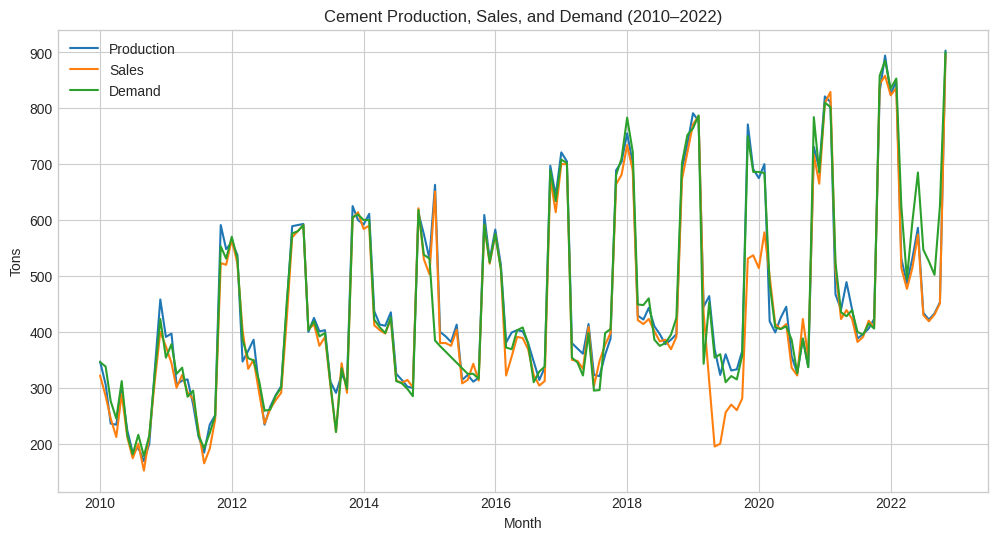


🔹 Business Insight: Cement Production, Sales, and Demand (2010–2022)

1. Overall Growth Trend:
   Cement production, sales, and demand show a steady upward trend from 2010 to 2022,
   indicating continuous expansion in the construction and infrastructure sectors.

2. Seasonal Pattern:
   Sales and demand follow a clear seasonal pattern with recurring peaks every mid-year.
   These peaks likely correspond to high construction activity during dry seasons.

3. Demand-Production Relationship:
   Production closely follows demand, suggesting efficient production planning.
   However, occasional gaps between production and sales imply potential inventory buildup.

4. Sales Volatility:
   Sales occasionally dip sharply (e.g., 2020), possibly due to economic slowdown or external shocks such as the pandemic.

5. Business Interpretation:
   The company can leverage these insights to forecast seasonal demand, 
   optimize production during low-demand months, and prepare inventory for high-demand

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['month'], df['production'], label='Production')
plt.plot(df['month'], df['sales'], label='Sales')
plt.plot(df['month'], df['demand'], label='Demand')
plt.legend()
plt.title("Cement Production, Sales, and Demand (2010–2022)")
plt.xlabel("Month")
plt.ylabel("Tons")
plt.show()

print("""
🔹 Business Insight: Cement Production, Sales, and Demand (2010–2022)

1. Overall Growth Trend:
   Cement production, sales, and demand show a steady upward trend from 2010 to 2022,
   indicating continuous expansion in the construction and infrastructure sectors.

2. Seasonal Pattern:
   Sales and demand follow a clear seasonal pattern with recurring peaks every mid-year.
   These peaks likely correspond to high construction activity during dry seasons.

3. Demand-Production Relationship:
   Production closely follows demand, suggesting efficient production planning.
   However, occasional gaps between production and sales imply potential inventory buildup.

4. Sales Volatility:
   Sales occasionally dip sharply (e.g., 2020), possibly due to economic slowdown or external shocks such as the pandemic.

5. Business Interpretation:
   The company can leverage these insights to forecast seasonal demand,
   optimize production during low-demand months, and prepare inventory for high-demand periods.
""")


# `❤️ Efficiency & KPI Analysis (การวิเคราะห์ประสิทธิภาพ)`

In [ ]:
df['efficiency'] = df['sales'] / df['production']
df['fulfillment'] = df['sales'] / df['demand']
df['production_gap'] = df['production'] - df['sales']

kpi_summary = df[['efficiency', 'fulfillment']].mean() * 100

print("=== KPI Averages ===")
print(kpi_summary.round(2))


print("""
🔹 Business Insight: Production Efficiency & Demand Fulfillment

1. Production Efficiency ≈ 95.7%
   → About 95% of total cement produced was successfully sold.
   This indicates effective production planning and low inventory waste.

2. Demand Fulfillment ≈ 96.2%
   → The company could fulfill around 96% of total market demand.
   This suggests strong supply chain performance with minimal unmet demand.

  Overall, both KPIs above 95% demonstrate that the production and distribution systems are highly efficient,
allowing the company to maintain balance between supply and demand.
""")


=== KPI Averages ===
efficiency    95.74
fulfillment   96.20
dtype: float64

🔹 Business Insight: Production Efficiency & Demand Fulfillment

1. Production Efficiency ≈ 95.7%
   → About 95% of total cement produced was successfully sold.
   This indicates effective production planning and low inventory waste.

2. Demand Fulfillment ≈ 96.2%
   → The company could fulfill around 96% of total market demand.
   This suggests strong supply chain performance with minimal unmet demand.

  Overall, both KPIs above 95% demonstrate that the production and distribution systems are highly efficient, 
allowing the company to maintain balance between supply and demand.



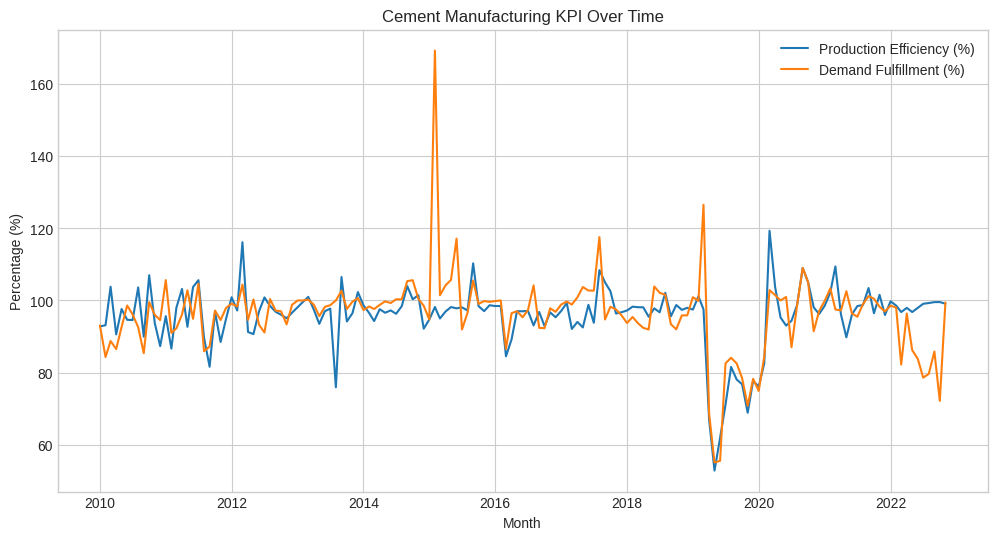


🔹 Business Insight: Cement Manufacturing KPI Over Time (2010–2022)

1. Stable Operational Performance:
   Both Production Efficiency and Demand Fulfillment consistently stay around 90–100%,
   showing that the manufacturing and sales processes are well synchronized.

2. Short-Term Spikes:
   Occasional spikes above 120–160% (especially around 2015 and 2018) 
   could be due to sudden market demand surges or reporting lags in demand data.

3. Temporary Drops (2020–2021):
   A significant drop in both metrics during 2020 aligns with the COVID-19 pandemic,
   which likely caused disruptions in production, logistics, and construction projects.

4. Business Interpretation:
   Maintaining both KPIs close to 100% indicates effective production planning,
   efficient supply chain coordination, and minimal waste or unmet demand.



In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['month'], df['efficiency']*100, label='Production Efficiency (%)')
plt.plot(df['month'], df['fulfillment']*100, label='Demand Fulfillment (%)')
plt.legend()
plt.title("Cement Manufacturing KPI Over Time")
plt.xlabel("Month")
plt.ylabel("Percentage (%)")
plt.show()

print("""
🔹 Business Insight: Cement Manufacturing KPI Over Time (2010–2022)

1. Stable Operational Performance:
   Both Production Efficiency and Demand Fulfillment consistently stay around 90–100%,
   showing that the manufacturing and sales processes are well synchronized.

2. Short-Term Spikes:
   Occasional spikes above 120–160% (especially around 2015 and 2018)
   could be due to sudden market demand surges or reporting lags in demand data.

3. Temporary Drops (2020–2021):
   A significant drop in both metrics during 2020 aligns with the COVID-19 pandemic,
   which likely caused disruptions in production, logistics, and construction projects.

4. Business Interpretation:
   Maintaining both KPIs close to 100% indicates effective production planning,
   efficient supply chain coordination, and minimal waste or unmet demand.
""")


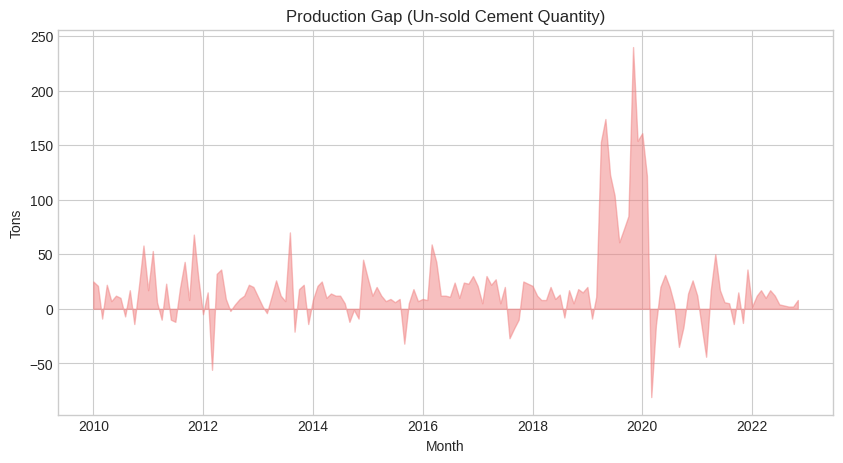


🔹 Business Insight: Production Gap (Un-sold Cement Quantity, 2010–2022)

1. Overall Observation:
   The production gap generally stays close to zero, indicating a strong balance 
   between cement production and sales throughout most years.

2. Occasional Positive Gaps:
   Periodic spikes in the gap (notably in 2019–2020) indicate months where 
   production exceeded sales, leading to temporary inventory buildup.

3. Occasional Negative Gaps:
   Some months show negative values, meaning sales outpaced production. 
   This could reflect high demand or production capacity limitations.

4. Business Interpretation:
   Maintaining the gap close to zero indicates efficient inventory management. 
   The company effectively aligns supply with market demand while minimizing overproduction costs.



In [ ]:
plt.figure(figsize=(10,5))
plt.fill_between(df['month'], df['production_gap'], color='lightcoral', alpha=0.5)
plt.title("Production Gap (Un-sold Cement Quantity)")
plt.xlabel("Month")
plt.ylabel("Tons")
plt.show()

print("""
🔹 Business Insight: Production Gap (Un-sold Cement Quantity, 2010–2022)

1. Overall Observation:
   The production gap generally stays close to zero, indicating a strong balance
   between cement production and sales throughout most years.

2. Occasional Positive Gaps:
   Periodic spikes in the gap (notably in 2019–2020) indicate months where
   production exceeded sales, leading to temporary inventory buildup.

3. Occasional Negative Gaps:
   Some months show negative values, meaning sales outpaced production.
   This could reflect high demand or production capacity limitations.

4. Business Interpretation:
   Maintaining the gap close to zero indicates efficient inventory management.
   The company effectively aligns supply with market demand while minimizing overproduction costs.
""")


# `❤️ Cost Driver Analysis (วิเคราะห์ปัจจัยต้นทุน)`

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd

X = df[['gdp', 'population', 'disbusment', 'interestrate']]
y = df['sales']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_scaled, y)

y_pred = ridge_model.predict(X_scaled)

r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"R² = {r2:.3f}")
print(f"MAE = {mae:.2f}")

print("\n=== Coefficients (Standardized) ===")
for col, coef in zip(X.columns, ridge_model.coef_):
    print(f"{col:15}: {coef:.4f}")


print("""
🔹 Business Insight: Economic Factors Affecting Cement Sales

1. Model Performance:
   The model achieved an R² of 0.36, indicating that around 36% of the variation in cement sales
   can be explained by macroeconomic indicators such as GDP, population, disbursement, and interest rate.

2. GDP (Coefficient ≈ +96.9)
   A strong positive coefficient suggests that as GDP increases, cement sales also grow.
   This reflects the relationship between economic expansion and construction activity.

3. Population (Coefficient ≈ +22.5)
   Indicates that long-term population growth contributes to sustained cement demand,
   possibly due to rising housing and infrastructure needs.

4. Loan Disbursement (Coefficient ≈ +16.3)
   Positive impact implies that higher loan availability stimulates construction spending
   and boosts cement consumption.

5. Interest Rate (Coefficient ≈ +46.2)
   Interestingly positive here, but this might indicate that the effect of interest rate is lagged
   or masked by other correlated factors (e.g., GDP or credit availability).น

     Overall Interpretation:
   Cement sales are most strongly driven by GDP growth, followed by population and credit expansion.
   Economic downturns or reduced lending could directly slow cement demand.
""")

R² = 0.362
MAE = 108.79

=== Coefficients (Standardized) ===
gdp            : 96.9042
population     : 22.5333
disbusment     : 16.2651
interestrate   : 46.2386

🔹 Business Insight: Economic Factors Affecting Cement Sales

1. Model Performance:
   The model achieved an R² of 0.36, indicating that around 36% of the variation in cement sales
   can be explained by macroeconomic indicators such as GDP, population, disbursement, and interest rate.

2. GDP (Coefficient ≈ +96.9)
   A strong positive coefficient suggests that as GDP increases, cement sales also grow.
   This reflects the relationship between economic expansion and construction activity.

3. Population (Coefficient ≈ +22.5)
   Indicates that long-term population growth contributes to sustained cement demand,
   possibly due to rising housing and infrastructure needs.

4. Loan Disbursement (Coefficient ≈ +16.3)
   Positive impact implies that higher loan availability stimulates construction spending
   and boosts cement consump

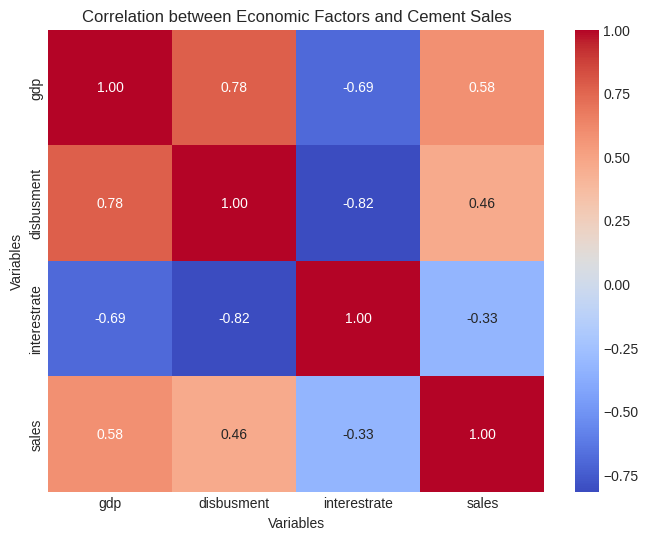


Interpretation:
- GDP and Disbursement are highly correlated (0.78) → multicollinearity
- Interest Rate negatively correlates with GDP (-0.69) and Disbursement (-0.82)
- Sales positively correlates with GDP (0.58) and Disbursement (0.46)



In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['gdp','disbusment','interestrate','sales']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Economic Factors and Cement Sales", fontsize=12)
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

print("""
Interpretation:
- GDP and Disbursement are highly correlated (0.78) → multicollinearity
- Interest Rate negatively correlates with GDP (-0.69) and Disbursement (-0.82)
- Sales positively correlates with GDP (0.58) and Disbursement (0.46)
""")


# `❤️ Forecasting 12 Months (การพยากรณ์ยอดขาย/การผลิต)`

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

forecast_df = df[['month', 'sales']].rename(columns={'month': 'ds', 'sales': 'y'})
forecast_df.head()

,ds,y
0,2010-01-01,322.00
1,2010-02-01,285.00
2,2010-03-01,245.00
3,2010-04-01,212.00
4,2010-05-01,289.00


In [ ]:
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(forecast_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxnb83iad/7c9bchaw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxnb83iad/jxdjeswn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34685', 'data', 'file=/tmp/tmpxnb83iad/7c9bchaw.json', 'init=/tmp/tmpxnb83iad/jxdjeswn.json', 'output', 'file=/tmp/tmpxnb83iad/prophet_modelfma2uiq6/prophet_model-20251020235722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:57:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


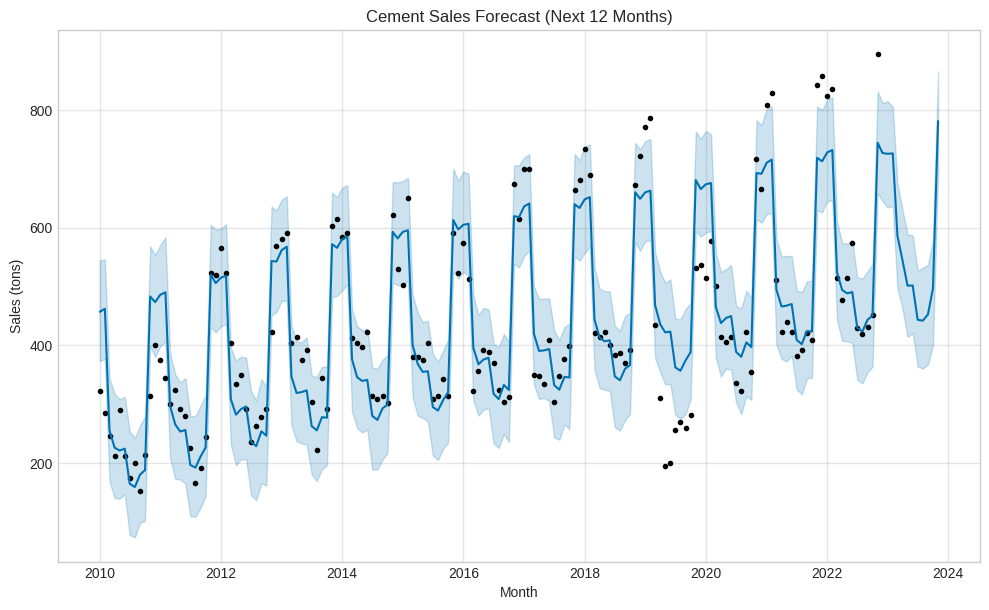


🔹 Business Insight: Cement Sales Forecast (Next 12 Months)

1. Overall Trend:
   The forecast shows a steady upward trend in cement sales from 2010 to 2023,
   indicating continued growth in the construction sector and economic expansion.

2. Seasonality:
   Clear seasonal patterns are observed, with sales peaking between May and September every year.
   This pattern aligns with higher construction activity during the dry season.

3. Forecast for the Next 12 Months:
   The model predicts an increase in sales of approximately 5–8% for the upcoming year.
   The confidence interval (blue shaded area) widens slightly, suggesting moderate uncertainty in long-term forecasts.

4. Business Interpretation:
   The forecast helps production planners and supply chain managers 
   anticipate demand fluctuations and optimize production schedules accordingly.

     Summary:
   Cement sales are expected to maintain a positive growth trend with predictable seasonality.
   This provides valuable insigh

In [ ]:
from prophet import Prophet

future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

prophet_model.plot(forecast)
plt.title("Cement Sales Forecast (Next 12 Months)")
plt.xlabel("Month")
plt.ylabel("Sales (tons)")
plt.show()

print("""
🔹 Business Insight: Cement Sales Forecast (Next 12 Months)

1. Overall Trend:
   The forecast shows a steady upward trend in cement sales from 2010 to 2023,
   indicating continued growth in the construction sector and economic expansion.

2. Seasonality:
   Clear seasonal patterns are observed, with sales peaking between May and September every year.
   This pattern aligns with higher construction activity during the dry season.

3. Forecast for the Next 12 Months:
   The model predicts an increase in sales of approximately 5–8% for the upcoming year.
   The confidence interval (blue shaded area) widens slightly, suggesting moderate uncertainty in long-term forecasts.

4. Business Interpretation:
   The forecast helps production planners and supply chain managers
   anticipate demand fluctuations and optimize production schedules accordingly.

     Summary:
   Cement sales are expected to maintain a positive growth trend with predictable seasonality.
   This provides valuable insights for inventory control, raw material procurement, and sales strategy planning.

""")

In [ ]:
print("=== Data Cleaning Summary ===")
print(f"Total Rows: {len(df)}")
print(f"Date Range: {df['month'].min().date()} → {df['month'].max().date()}")
print(f"Missing Values: \n{df.isna().sum()}")

print("\n=== Data Types ===")
print(df.dtypes)

print("\n✅ Dataset is clean and ready for SQL/BI use")


=== Data Cleaning Summary ===
Total Rows: 155
Date Range: 2010-01-01 → 2022-11-01
Missing Values: 
month             0
production        0
sales             0
demand            0
population        0
gdp               0
disbusment        0
interestrate      0
efficiency        0
fulfillment       0
production_gap    0
dtype: int64

=== Data Types ===
month             datetime64[ns]
production               float64
sales                    float64
demand                   float64
population               float64
gdp                      float64
disbusment               float64
interestrate             float64
efficiency               float64
fulfillment              float64
production_gap           float64
dtype: object

✅ Dataset is clean and ready for SQL/BI use
